In [4]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2026-01-22 01:06:32.787160: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-22 01:06:32.892563: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-22 01:06:32.892609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-22 01:06:32.906216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-22 01:06:32.937859: I tensorflow/core/platform/cpu_feature_guar

In [5]:
# %matplotlib inline
# mpl.pyplot.style.use('default')
# mpl.pyplot.close('all')

# font, rcnew = plot_utils.matplotlib_default_config()
# mpl.rc('font', **font)
# mpl.pyplot.rcParams.update(rcnew)
# mpl.pyplot.style.use('tableau-colorblind10')
# %config InlineBackend.figure_format = 'retina'

# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12

# test on single

In [6]:
tag_params = '_p5_n10000'
idx_LH = 0

# change this directory path as needed
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib{tag_params}'
subdir_prefix = 'LH'
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
bias_terms_eul = np.load(fn_fields)


In [13]:
#the order is b1, b2, bs2, blaplacian
#bias_params = [1, 0, 0, 0]
bias_params = [1.2, 0.5, 0.25, 5]

# use 512 for normalization, because this is the original resolution of the mocks (they were downsampled to 128)
# this doesn't matter for visualization, but will when you go to compute statistics
n_grid_orig = 512
tracer_field = utils.get_tracer_field(bias_terms_eul, bias_params, n_grid_norm=n_grid_orig)

In [14]:
box_size = 1000 # Mpc/h
n_grid = 128 

In [15]:
params_df, param_dict_fixed = data_loader.load_cosmo_params(tag_params)
param_dict = params_df.loc[idx_LH].to_dict()
cosmo = utils.get_cosmo(param_dict)

In [16]:
matter_density_field = bias_terms_eul[1]
pgm_obj = cs.compute_pgm(tracer_field, matter_density_field, cosmo, box_size, n_grid_orig)

Computing pgm, using n_grid =  128


2026-01-22 01:07:19,584 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 6.31307e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002340 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.079373 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000131 secs
bacco.power : Deallocating arrays


2026-01-22 01:07:20,430 bacco.statistics :  ...done in 0.846 s


In [17]:
pk_obj = cs.compute_pk(tracer_field, cosmo, box_size, n_grid_orig)

Computing pk, using n_grid =  128


2026-01-22 01:07:20,835 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0


2026-01-22 01:07:21,140 bacco.statistics :  ...done in 0.305 s


bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002405 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.026766 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000135 secs
bacco.power : Deallocating arrays


/tmp/ipykernel_2026127/847835007.py:15: RuntimeWarning: invalid value encountered in divide
  frac_diff = (pk_obj['pk'] - pgm_obj['pk']) / pgm_obj['pk']


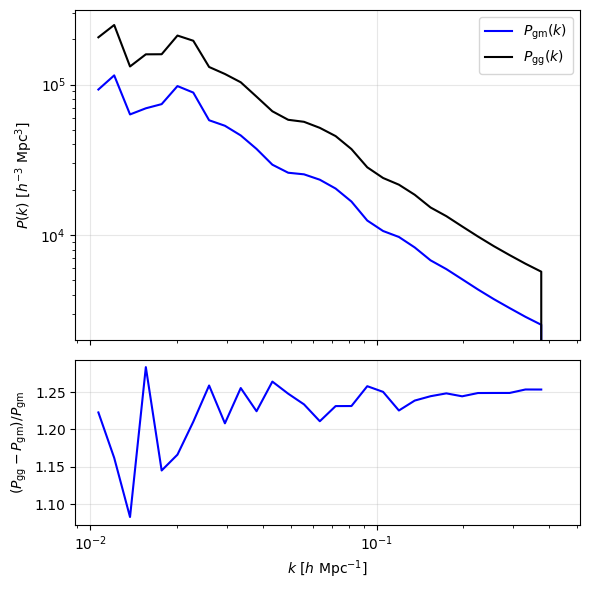

In [24]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Upper panel: power spectra
ax1.plot(pgm_obj['k'], pgm_obj['pk'], label=r'$P_{\rm gm}(k)$', color='blue')
ax1.plot(pk_obj['k'], pk_obj['pk'], label=r'$P_{\rm gg}(k)$', color='k')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Lower panel: fractional difference
# Assume k bins are the same
frac_diff = (pk_obj['pk'] - pgm_obj['pk']) / pgm_obj['pk']

ax2.plot(pgm_obj['k'], frac_diff, color='blue', linewidth=1.5)
#ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.set_xscale('log')
ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$')
ax2.set_ylabel(r'$(P_{\rm gg} - P_{\rm gm}) / P_{\rm gm}$')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()